### Manual implementation of `fwd()` to extract LayerNorm inputs & outputs

In [1]:
from transformers.models.gpt2.modeling_gpt2 import GPT2Block
from transformers import GPT2Tokenizer
from typing import Optional, Tuple, Union
import torch
from transformers import GPT2Model, GPT2Config

# Apply Top-K by magniture to LayerNorm and Residual connection - the densifying operations in a Transformer
class TestModifyGPT2Block(GPT2Block):
    def __init__(self, config, layer_idx=None):
        super().__init__(config, layer_idx=None)
        
    def forward(
        self,
        hidden_states: Optional[Tuple[torch.FloatTensor]],
        layer_past: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = False,
        output_attentions: Optional[bool] = False,
    ) -> Union[Tuple[torch.Tensor], Optional[Tuple[torch.Tensor, Tuple[torch.FloatTensor, ...]]]]:
        residual = hidden_states  # Identical debug to GPT2Block so far
        hidden_states = self.ln_1(hidden_states) # Also identical
        attn_outputs = self.attn(
            hidden_states,
            layer_past=layer_past,
            attention_mask=attention_mask,
            head_mask=head_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
        )
        attn_output = attn_outputs[0]  # output_attn: a, present, (attentions)
        outputs = attn_outputs[1:]  # This is where differences start
        # residual connection
        hidden_states = attn_output + residual

        if encoder_hidden_states is not None:
            # add one self-attention block for cross-attention
            if not hasattr(self, "crossattention"):
                raise ValueError(
                    f"If `encoder_hidden_states` are passed, {self} has to be instantiated with "
                    "cross-attention layers by setting `config.add_cross_attention=True`"
                )
            residual = hidden_states
            hidden_states = self.ln_cross_attn(hidden_states)
            cross_attn_outputs = self.crossattention(
                hidden_states,
                attention_mask=attention_mask,
                head_mask=head_mask,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_attention_mask,
                output_attentions=output_attentions,
            )
            attn_output = cross_attn_outputs[0]
            # residual connection
            hidden_states = residual + attn_output
            outputs = outputs + cross_attn_outputs[2:]  # add cross attentions if we output attention weights

        residual = hidden_states
        hidden_states = self.ln_2(hidden_states)
        feed_forward_hidden_states = self.mlp(hidden_states)
        # residual connection
        hidden_states = residual + feed_forward_hidden_states

        if use_cache:
            outputs = (hidden_states,) + outputs
        else:
            outputs = (hidden_states,) + outputs[1:]

        return outputs  # hidden_states, present, (attentions, cross_attentions)

In [2]:
from torch import nn

# This model should be identical to GPT2Model, used to verify functions defined below
# After verification, will use TopKLayerNormGPT2Block instead of GPT2Block, then check the difference in accuracy/perplexity
class GPT2TestModifiedModel(GPT2Model):
    def __init__(self, config):
        super().__init__(config)

        self.embed_dim = config.hidden_size

        self.wte = nn.Embedding(config.vocab_size, self.embed_dim)
        self.wpe = nn.Embedding(config.max_position_embeddings, self.embed_dim)

        self.drop = nn.Dropout(config.embd_pdrop)
        self.h = nn.ModuleList([TestModifyGPT2Block(config, layer_idx=i) for i in range(config.num_hidden_layers)])
        self.ln_f = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_epsilon)

        # Model parallel
        self.model_parallel = False
        self.device_map = None
        self.gradient_checkpointing = False
        self._attn_implementation = config._attn_implementation

        # Initialize weights and apply final processing
        self.post_init()

#### Verify Correctness against stock GPT-2 at same layer

In [3]:
def compare_model_params(model1, model2):
    # Disable non-deterministic behavior
    torch.manual_seed(0)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(0)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Ensure both models start with the same weights
    model2.load_state_dict(model1.state_dict())
    model2.h[0].load_state_dict(model1.h[0].state_dict())

    # Compare all named parameters
    params_dict_original = {name: param for name, param in model1.named_parameters()}
    params_dict_modified = {name: param for name, param in model2.named_parameters()}

    # Now you can access by name
    for name in params_dict_original:
        assert torch.allclose(params_dict_original[name], params_dict_modified[name], atol=1e-6), f"Mismatch found in parameter: {name}"


    def compare_state_dicts(dict1, dict2):
        # Check if both dictionaries have the same set of keys (parameter names)
        assert dict1.keys() == dict2.keys(), "State dicts have different sets of parameters."
        
        # Check if all tensors in both dictionaries are close
        for key in dict1:
            assert torch.allclose(dict1[key], dict2[key], atol=1e-6), f"Mismatch found in parameter: {key}"

    # Prepare input
    input_ids = torch.tensor([[12100, 242, 508, 318, 13, 198]])

    hidden_states_original = model1.wte(input_ids)
    hidden_states_modified = model2.wte(input_ids)
    assert torch.allclose(hidden_states_original, hidden_states_modified, atol=1e-6), "Embedding output mismatch"
    print("Word Token Embeddings output match")

    # modified_model.load_state_dict(original_model.state_dict())
    # modified_model.h[0].load_state_dict(original_model.h[0].state_dict())

    # Compare state dicts
    state_dict1 = model1.state_dict()
    state_dict2 = model2.state_dict()

    compare_state_dicts(state_dict1, state_dict2)
    print("State Dicts match")


    def compare_attention_params(model1, model2, layer_index=0):
        attn1 = model1.h[layer_index].attn
        attn2 = model2.h[layer_index].attn
        
        # Convert generators to dictionaries
        params1 = dict(attn1.named_parameters())
        params2 = dict(attn2.named_parameters())

        # Now params1 and params2 are dictionaries that can be accessed by keys
        for name in params1:
            param1 = params1[name]
            param2 = params2[name]
            if not torch.allclose(param1, param2, atol=1e-6):
                print(f"Mismatch in {name}")
                print(f"Model1: {param1}")
                print(f"Model2: {param2}")

    # Call this function with your models
    for i in range(12):
        compare_attention_params(model1, model2, i)
    print("Attention parameters match")


    original_h0 = model1.h[0](hidden_states_original)[0]
    modified_h0 = model2.h[0](hidden_states_modified)[0]  # Input is the same. These are still different
    # modified_h0 = modified_model.h[0](hidden_states_modified)[0]
    assert torch.allclose(original_h0, modified_h0, atol=1e-6), "First Hidden State output mismatch"
    print("First Hidden State output match")

    model1.h[0].attn.c_attn.weight


    # Get outputs from both models
    with torch.no_grad():
        original_output = model1(input_ids)[0]
        modified_output = model2(input_ids)[0]

    # at = model2(input_ids)#.attn
    # Compare outputs
    # print("Difference between original and modified model outputs:", torch.sum((original_output - modified_output) ** 2))
    print("original_output: ", original_output)
    print("modified_output: ", modified_output)

    assert torch.allclose(original_output, modified_output, atol=1e-6), "Final output mismatch"
    print("Final output matches")


config = GPT2Config()
original_model = GPT2Model(config).eval()
# modified_model = GPT2Model(config).eval()  # Assigning h[0] = CustomGPT2Block does not work!
modified_model = GPT2TestModifiedModel(config).eval()

compare_model_params(original_model, modified_model)

Word Token Embeddings output match
State Dicts match
Attention parameters match
First Hidden State output match
original_output:  tensor([[[-1.0928,  1.3093,  0.8949,  ...,  0.9977, -0.2158,  0.3708],
         [-0.1311, -0.1867, -0.1559,  ...,  0.2637,  0.2444, -0.8348],
         [-0.9530,  0.7968,  2.1784,  ...,  0.2839, -1.3077,  0.6010],
         [ 0.1176,  0.1615,  1.3768,  ...,  0.4297, -0.4278,  0.0996],
         [-1.1153,  0.9814,  1.7994,  ..., -0.7483,  0.1421, -0.4134],
         [-0.8643,  2.2702,  2.3388,  ...,  0.5788, -0.7693,  0.3393]]])
modified_output:  tensor([[[-1.0928,  1.3093,  0.8949,  ...,  0.9977, -0.2158,  0.3708],
         [-0.1311, -0.1867, -0.1559,  ...,  0.2637,  0.2444, -0.8348],
         [-0.9530,  0.7968,  2.1784,  ...,  0.2839, -1.3077,  0.6010],
         [ 0.1176,  0.1615,  1.3768,  ...,  0.4297, -0.4278,  0.0996],
         [-1.1153,  0.9814,  1.7994,  ..., -0.7483,  0.1421, -0.4134],
         [-0.8643,  2.2702,  2.3388,  ...,  0.5788, -0.7693,  0.3393]

In [4]:
# Define LMHead for custom GPT architecture to make it do language tasks
# From https://chat.openai.com/share/84b66b97-f257-46a5-8f5b-4afa36965013
class GPT2TopKLMHeadModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.lm_head = nn.Linear(base_model.config.hidden_size, base_model.config.vocab_size, bias=False)

        # You may want to tie the weights as done in the GPT2 pre-trained models
        self.tie_weights()

    def tie_weights(self):
        """ Make sure we are sharing the embeddings and the output weights, tying them """
        self.lm_head.weight = self.base_model.wte.weight

    def forward(self, input_ids, attention_mask=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        logits = self.lm_head(sequence_output)

        return logits

#### Sanity check for both models

In [ ]:
from transformers import GPT2LMHeadModel
from copy import deepcopy

torch.manual_seed(0)

config = GPT2Config.from_pretrained('gpt2-medium')

# original_gpt2_with_head = GPT2LMHeadModel.from_pretrained("gpt2-medium").eval()

original_model = GPT2Model(config)
original_model_with_gpt2_head = GPT2LMHeadModel(config)
original_model_with_gpt2_head.transformer = original_model

original_model_with_gpt2_head = original_model_with_gpt2_head.eval()

# These should definitely be identical
modified_model = GPT2Model(config)

modified_model.load_state_dict(original_model.state_dict())

# modified_model = GPT2TopKModel(config)
modified_model_with_gpt2_head = GPT2LMHeadModel(config)
modified_model_with_gpt2_head.transformer = modified_model

modified_model_with_gpt2_head = modified_model_with_gpt2_head.eval()

modified_model_with_gpt2_head.lm_head.load_state_dict(original_model_with_gpt2_head.lm_head.state_dict())

In [ ]:
modified_model_with_gpt2_head.lm_head.load_state_dict(original_model_with_gpt2_head.lm_head.state_dict())

<All keys matched successfully>

In [ ]:
compare_model_params(original_model, modified_model) # so this works

Word Token Embeddings output match
State Dicts match
Attention parameters match
First Hidden State output match
original_output:  tensor([[[ 1.3025,  0.0891,  1.5785,  ..., -0.7348,  1.3662, -0.0760],
         [ 1.0428, -0.0767,  1.0057,  ..., -1.0282,  2.3909,  0.0945],
         [ 0.3019, -0.7627,  0.9617,  ..., -0.5008,  1.7748,  0.4493],
         [ 1.0860, -0.4353,  0.8214,  ..., -0.2734,  1.0454, -0.1068],
         [ 1.1729, -0.5770,  1.1421,  ..., -0.7705,  0.6708,  0.8564],
         [ 1.0173, -0.1443,  1.4305,  ..., -1.1474,  1.7968,  0.4672]]])
modified_output:  tensor([[[ 1.3025,  0.0891,  1.5785,  ..., -0.7348,  1.3662, -0.0760],
         [ 1.0428, -0.0767,  1.0057,  ..., -1.0282,  2.3909,  0.0945],
         [ 0.3019, -0.7627,  0.9617,  ..., -0.5008,  1.7748,  0.4493],
         [ 1.0860, -0.4353,  0.8214,  ..., -0.2734,  1.0454, -0.1068],
         [ 1.1729, -0.5770,  1.1421,  ..., -0.7705,  0.6708,  0.8564],
         [ 1.0173, -0.1443,  1.4305,  ..., -1.1474,  1.7968,  0.4672]

In [ ]:
input_ids = torch.tensor([[50256, 318, 262, 263, 734, 262, 1576, 50256]])  # Random example tokens

# Generate outputs with hidden states and attentions
outputs_original = original_model_with_gpt2_head(input_ids, output_hidden_states=True, output_attentions=True)
outputs_modified = modified_model_with_gpt2_head(input_ids, output_hidden_states=True, output_attentions=True)

# Accessing the logits, hidden states, and attentions
logits_original, hidden_states_original, attentions_original = outputs_original.logits, outputs_original.hidden_states, outputs_original.attentions
logits_modified, hidden_states_modified, attentions_modified = outputs_modified.logits, outputs_modified.hidden_states, outputs_modified.attentions

In [ ]:
torch.allclose(logits_original, logits_modified, atol=1e-6)  # This should be True
torch.allclose(hidden_states_original[0], hidden_states_modified[0])
torch.allclose(hidden_states_original[1], hidden_states_modified[1])
torch.allclose(attentions_original[0], attentions_modified[0])
torch.allclose(attentions_original[1], attentions_modified[1])

True

In [ ]:
logits_original

tensor([[[-0.5882, -0.1566,  0.9692,  ...,  1.6813,  0.2022,  0.7559],
         [-0.8870, -0.0666,  0.8193,  ...,  1.7804, -0.2431, -0.2938],
         [-0.0335,  0.2815,  0.4804,  ...,  1.5229, -0.0332,  0.3242],
         ...,
         [-0.4287, -0.7156,  0.6954,  ...,  0.8741, -0.5616,  0.4157],
         [-0.4121, -0.3123,  0.4581,  ...,  0.6161,  0.0355,  0.3238],
         [ 0.3711,  0.3823, -0.2987,  ...,  1.0961, -0.8531,  0.6987]]],
       grad_fn=<UnsafeViewBackward0>)

In [ ]:
logits_modified

tensor([[[-0.5882, -0.1566,  0.9692,  ...,  1.6813,  0.2022,  0.7559],
         [-0.8870, -0.0666,  0.8193,  ...,  1.7804, -0.2431, -0.2938],
         [-0.0335,  0.2815,  0.4804,  ...,  1.5229, -0.0332,  0.3242],
         ...,
         [-0.4287, -0.7156,  0.6954,  ...,  0.8741, -0.5616,  0.4157],
         [-0.4121, -0.3123,  0.4581,  ...,  0.6161,  0.0355,  0.3238],
         [ 0.3711,  0.3823, -0.2987,  ...,  1.0961, -0.8531,  0.6987]]],
       grad_fn=<UnsafeViewBackward0>)

In [ ]:
def sanity_check_model(model1_with_head, model2_with_head):
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium")

    prompt = "What is the capital of France?"
    inputs = tokenizer.encode(prompt, return_tensors="pt")

    # Generate responses
    output_sequences_1 = model1_with_head.generate(inputs, max_length=50, num_return_sequences=1)
    output_sequences_2 = model2_with_head.generate(inputs, max_length=50, num_return_sequences=1)

    # Decode generated sequences to text
    generated_text_1 = tokenizer.decode(output_sequences_1[0], skip_special_tokens=True)
    generated_text_2 = tokenizer.decode(output_sequences_2[0], skip_special_tokens=True)

    print("Response from Model 1:", generated_text_1)
    print("Response from Model 2:", generated_text_2)

    input_ids = torch.tensor([[50256, 318, 262, 263, 734, 262, 1576, 50256]])  # Random example tokens

    # Generate outputs with hidden states and attentions
    outputs_original = model1_with_head(input_ids, output_hidden_states=True, output_attentions=True)
    outputs_modified = model2_with_head(input_ids, output_hidden_states=True, output_attentions=True)

    # Accessing the logits, hidden states, and attentions
    logits_original, hidden_states_original, attentions_original = outputs_original.logits, outputs_original.hidden_states, outputs_original.attentions
    logits_modified, hidden_states_modified, attentions_modified = outputs_modified.logits, outputs_modified.hidden_states, outputs_modified.attentions

    print("Comparing outputs of the two models with torch.allclose()")
    assert torch.allclose(logits_original, logits_modified, atol=1e-6), "Logits DO NOT match" 
    assert torch.allclose(hidden_states_original[0], hidden_states_modified[0]), "Hidden States DO NOT match"
    assert torch.allclose(hidden_states_original[1], hidden_states_modified[1]), "Hidden States DO NOT match"
    assert torch.allclose(attentions_original[0], attentions_modified[0]), "Attentions DO NOT match"
    assert torch.allclose(attentions_original[1], attentions_modified[1]), "Attentions DO NOT match"

In [ ]:
sanity_check_model(original_model_with_gpt2_head, modified_model_with_gpt2_head)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Response from Model 1: What is the capital of France?MajorMajorMajor Duty TelecommunicationsMajorather TelecommunicationsRPG 234RPG TestsRPG mouthHourRPG mouth maintenance420 deteriorating Duty Telecommunications420TexRPGorth petsoptions Trent Anonymous Duty Documents bip Documents TelecommunicationsCoach Erica tool slaves contingent restrictionDb Telecommunications
Response from Model 2: What is the capital of France?MajorMajorMajor Duty TelecommunicationsMajorather TelecommunicationsRPG 234RPG TestsRPG mouthHourRPG mouth maintenance420 deteriorating Duty Telecommunications420TexRPGorth petsoptions Trent Anonymous Duty Documents bip Documents TelecommunicationsCoach Erica tool slaves contingent restrictionDb Telecommunications
Comparing outputs of the two models with torch.allclose()


### Now try initializing from Pretrained model. The previous output is gibberish, though identical

In [ ]:
from transformers import GPT2LMHeadModel
from copy import deepcopy

torch.manual_seed(0)

# config = GPT2Config.from_pretrained('gpt2-medium')

original_gpt2_with_head = GPT2LMHeadModel.from_pretrained("gpt2-medium").eval()

# These should definitely be identical
# modified_model = GPT2Model(config)
modified_model = GPT2TestModifiedModel(config)

# Crucial to copy the state if we want same starting parameters
modified_model.load_state_dict(original_gpt2_with_head.transformer.state_dict())

modified_model_with_gpt2_head = GPT2LMHeadModel(config)
modified_model_with_gpt2_head.transformer = modified_model

modified_model_with_gpt2_head = modified_model_with_gpt2_head.eval()

modified_model_with_gpt2_head.lm_head.load_state_dict(original_gpt2_with_head.lm_head.state_dict())

<All keys matched successfully>

In [ ]:
sanity_check_model(original_gpt2_with_head, modified_model_with_gpt2_head)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Response from Model 1: What is the capital of France?

The capital of France is Paris.

What is the capital of France?

The capital of France is Paris.

What is the capital of France?

The capital of France is
Response from Model 2: What is the capital of France?

The capital of France is Paris.

What is the capital of France?

The capital of France is Paris.

What is the capital of France?

The capital of France is
Comparing outputs of the two models with torch.allclose()


### Full perplexity check

In [ ]:
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np


def compare_model_perplexity(model1, model2, dataset_name: str = "Trelis/tiny-shakespeare", n_rows: int = None, batch_size=4):
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium")
    # We need a padding token for DataLoader
    tokenizer.pad_token = tokenizer.eos_token
    model1 = model1.eval()
    model2 = model2.eval()

    dataset = load_dataset(dataset_name)
    text_data = dataset['train']['Text']

    # If n_rows is specified, slice the dataset
    if n_rows is not None:
        text_data = text_data[:n_rows]

    # Tokenization
    def encode(text):
        return tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding="max_length")['input_ids']
    
    input_ids = torch.cat([encode(text) for text in text_data], dim=0)

    # Create DataLoader for batch processing
    loader = DataLoader(input_ids, batch_size=batch_size, shuffle=False)

    # Initialize variables to compute perplexity
    total_loss_original = 0
    total_loss_modified = 0
    total_items = 0

    # Disable gradients for evaluation
    with torch.no_grad():
        for batch in loader:
            model1_outputs = model1(batch)
            model2_outputs = model2(batch)

            # Calculate loss for the batch
            shift_logits_original = model1_outputs.logits[..., :-1, :].contiguous()
            shift_labels_original = batch[..., 1:].contiguous()
            loss_original = F.cross_entropy(shift_logits_original.view(-1, shift_logits_original.size(-1)), shift_labels_original.view(-1))

            shift_logits_modified = model2_outputs.logits[..., :-1, :].contiguous()
            shift_labels_modified = batch[..., 1:].contiguous()
            loss_modified = F.cross_entropy(shift_logits_modified.view(-1, shift_logits_modified.size(-1)), shift_labels_modified.view(-1))

            total_loss_original += loss_original.item() * batch.size(0)
            total_loss_modified += loss_modified.item() * batch.size(0)
            total_items += batch.size(0)

    # Calculate perplexity
    perplexity_original = np.exp(total_loss_original / total_items)
    perplexity_modified = np.exp(total_loss_modified / total_items)

    print(f"Perplexity of Original Model: {perplexity_original}")
    print(f"Perplexity of Modified Model: {perplexity_modified}")

In [ ]:
compare_model_perplexity(original_gpt2_with_head, modified_model_with_gpt2_head, n_rows=10)

Perplexity of Original Model: 43.60431929524889
Perplexity of Modified Model: 43.60431929524889


## <font color="green"> Perplexity score matches on first 10 rows! </font>

Try with whole Tiny Shakespeare dataset

In [ ]:
compare_model_perplexity(original_gpt2_with_head, modified_model_with_gpt2_head, batch_size=15)  # Bigger batches cause memory issues

Need to load same state dicts if i want to compare different models

In [22]:
input_ids = torch.tensor([[12100, 242, 508, 318, 13, 198]])

out = topk_model(input_ids)

### Plotting & Heatmapping LayerNorm

In [28]:
h0_inter = topk_model.h[0].intermediate_outputs

In [30]:
h0_inter.keys()

dict_keys(['initial_residual', 'initial_hidden_states', 'post_ln1_residual', 'post_ln1_hidden_states', 'attn_output', 'post_attn_residual_hidden_states', 'post_cross_attn_residual', 'post_cross_attn_hidden_states', 'post_ln2_residual', 'post_ln2_hidden_states', 'post_feed_fwd_hidden_states', 'post_feed_fwd_residual_hidden_states'])

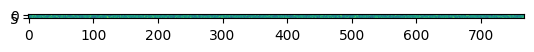

In [32]:
from matplotlib import pyplot as plt

plt.imshow(topk_model.h[0].intermediate_outputs['post_ln1_residual'][0])

In [33]:
from utils.datasets import get_top_n_tiny_shakespeare

longest_shakespeare = get_top_n_tiny_shakespeare(1, mode="longest")[0]['Text']
longest_shakespeare

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


"Our king, being ready to leap out of\nhimself for joy of his found daughter, as if that\nOur king, being ready to leap out of\njoy were now become a loss, cries 'O, thy mother,\nthy mother!' then asks Bohemia forgiveness; then\nembraces his son-in-law; then again worries he his\ndaughter with clipping her; now he thanks the old\nshepherd, which stands by like a weather-bitten\nconduit of many kings' reigns. I never heard of such\nanother encounter, which lames report to follow it\nand undoes description to do it.\n\nSecond Gentleman:\nWhat, pray you, became of Antigonus, that carried\nhence the child?\n\nThird Gentleman:\nLike an old tale still, which will have matter to\nrehearse, though credit be asleep and not an ear\nopen. He was torn to pieces with a bear: this\navouches the shepherd's son; who has not only his\ninnocence, which seems much, to justify him, but a\nhandkerchief and rings of his that Paulina knows.\n\nFirst Gentleman:\nWhat became of his bark and his followers?\n\nT

In [34]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium")

input_ids = tokenizer.encode(longest_shakespeare, return_tensors="pt")
outputs = topk_model(input_ids)

In [35]:
h0_inter = topk_model.h[0].intermediate_outputs

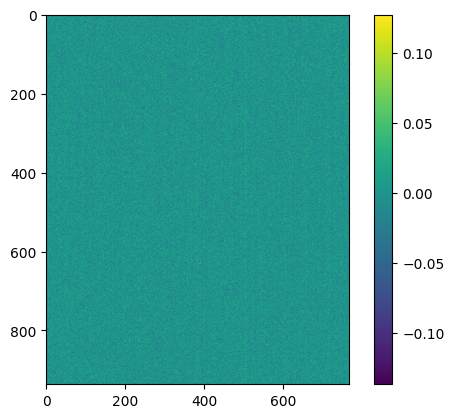

In [37]:
plt.imshow(topk_model.h[0].intermediate_outputs['post_ln1_residual'][0])
plt.colorbar()

In [41]:
h0_inter['attn_output'].shape

torch.Size([1, 937, 768])

In [44]:
from transformers import GPT2LMHeadModel

topk_model_with_gpt2_head = GPT2LMHeadModel(config)

topk_model_with_gpt2_head.transformer = topk_model

topk_model_with_gpt2_head = topk_model_with_gpt2_head.eval()

In [69]:
res = topk_model_with_gpt2_head(input_ids, output_attentions=True)

In [65]:
res['attentions']

(tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [3.7149e-01, 6.2851e-01, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [2.2992e-01, 3.7514e-01, 3.9494e-01,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [1.4934e-03, 7.8581e-04, 6.6491e-04,  ..., 9.4806e-04,
            0.0000e+00, 0.0000e+00],
           [1.1797e-03, 9.5534e-04, 1.0613e-03,  ..., 1.8094e-03,
            1.1233e-03, 0.0000e+00],
           [9.2516e-04, 1.0462e-03, 1.0005e-03,  ..., 7.4501e-04,
            1.1784e-03, 9.8825e-04]],
 
          [[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [4.8272e-01, 5.1728e-01, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [3.1384e-01, 2.4319e-01, 4.4297e-01,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [1.2918e-03, 1.6636e-03, 1.

In [66]:
res['attentions'][0].shape

torch.Size([1, 12, 937, 937])

In [1]:
res['attentions'][0]

NameError: name 'res' is not defined

In [67]:
res['attentions'][1].shape

torch.Size([1, 12, 937, 937])

In [68]:
torch.allclose(res['attentions'][0], res['attentions'][1])

False

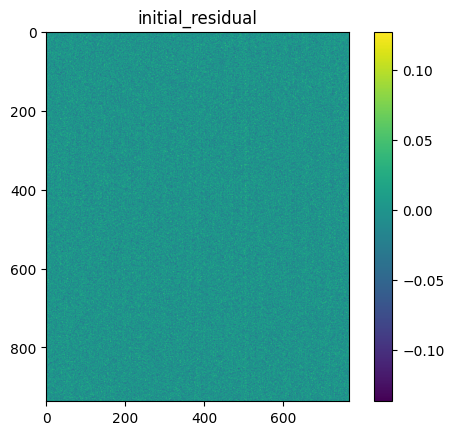

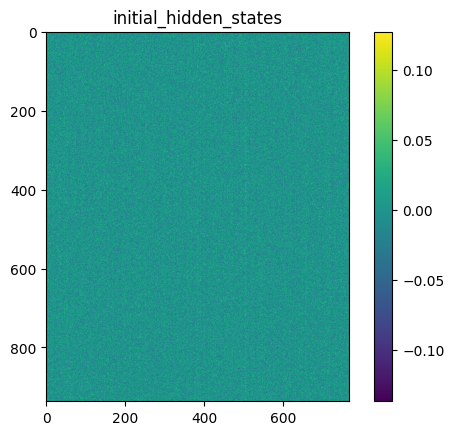

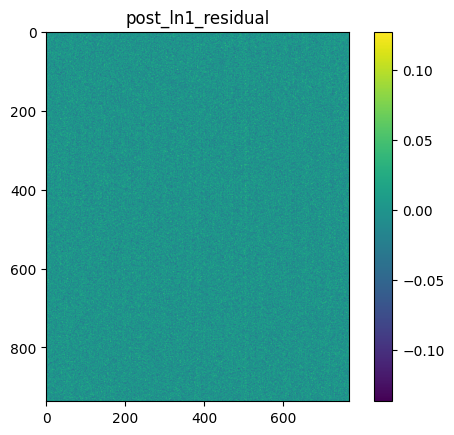

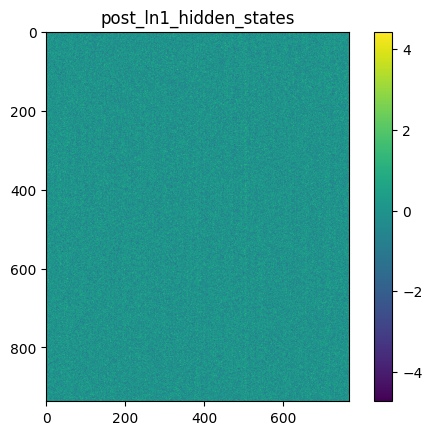

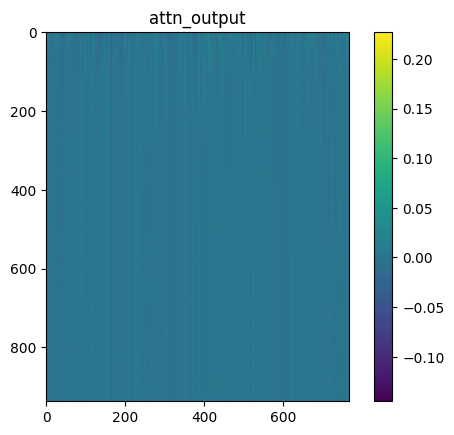

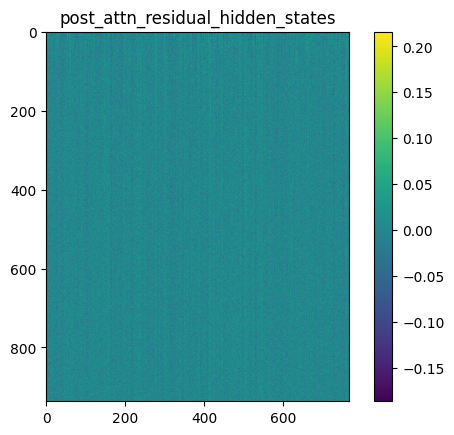

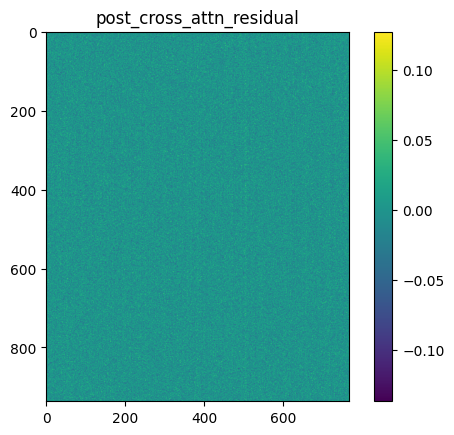

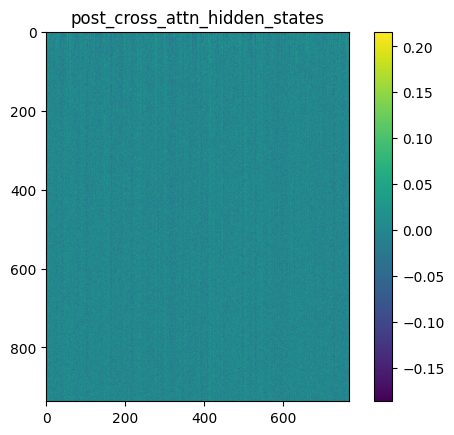

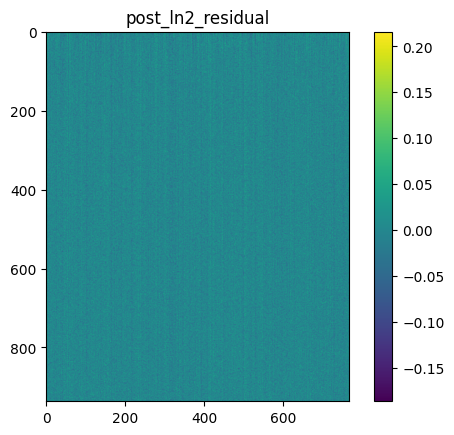

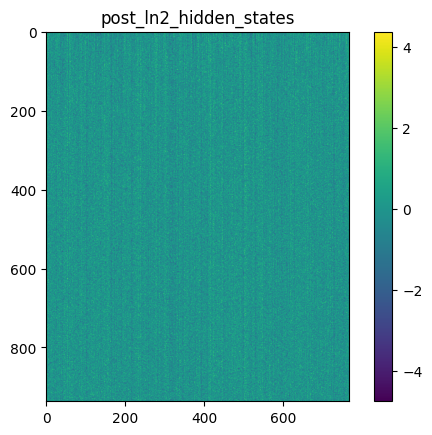

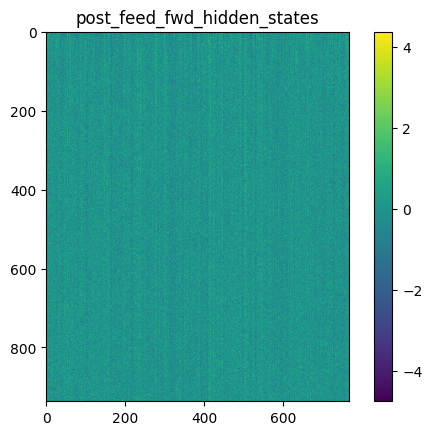

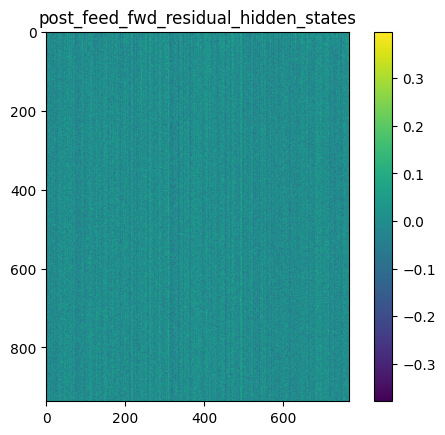

In [38]:
for key in h0_inter.keys():
    plt.figure()
    plt.imshow(h0_inter[key][0])
    plt.title(key)
    plt.colorbar()

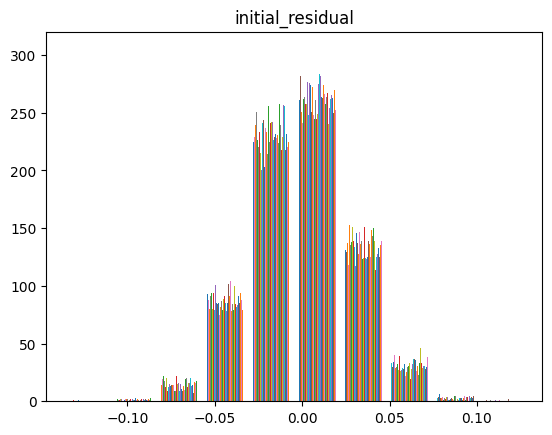

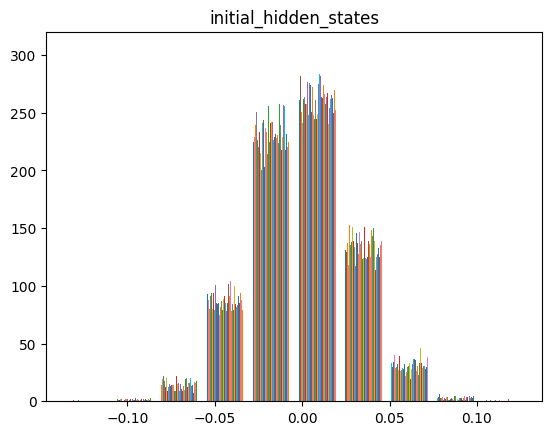

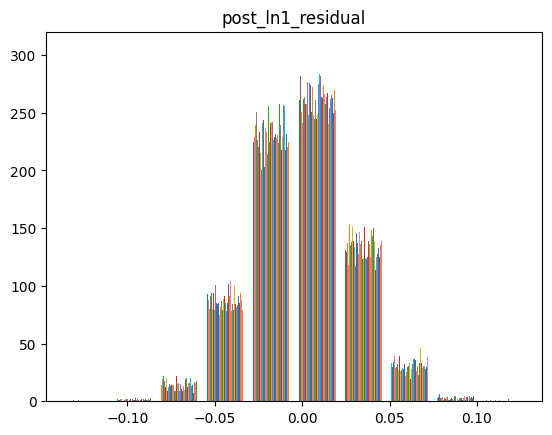

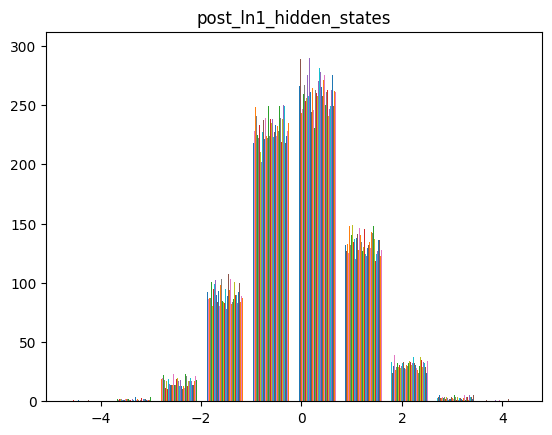

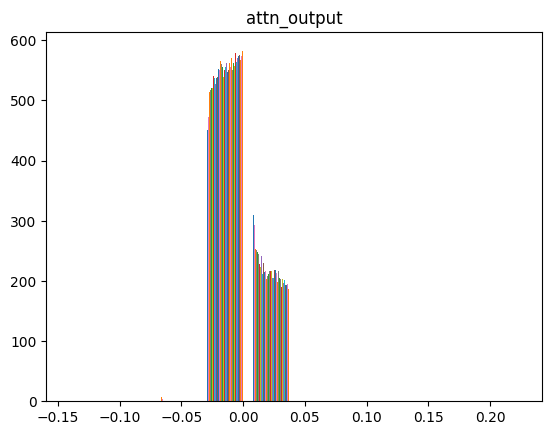

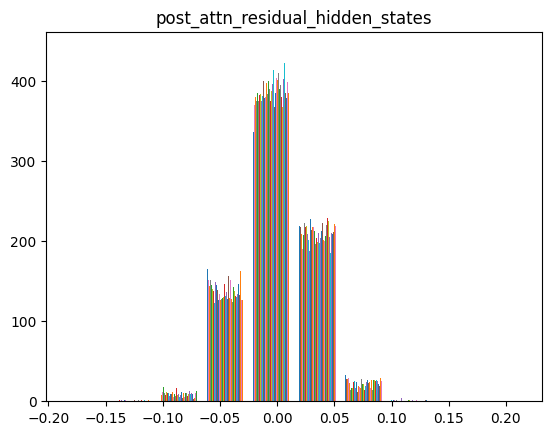

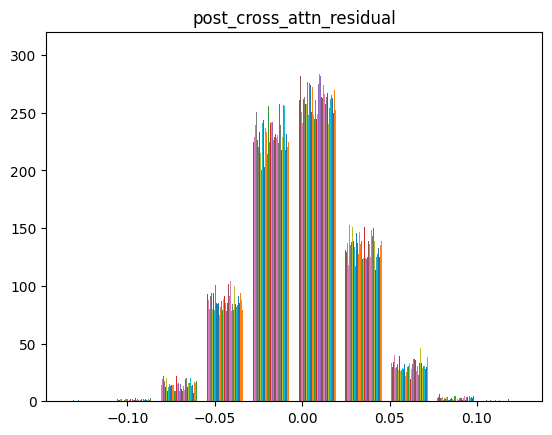

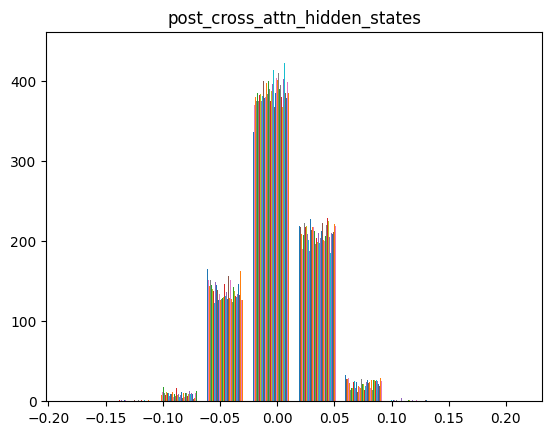

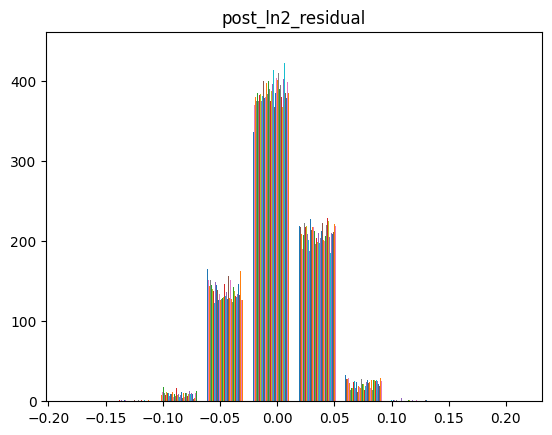

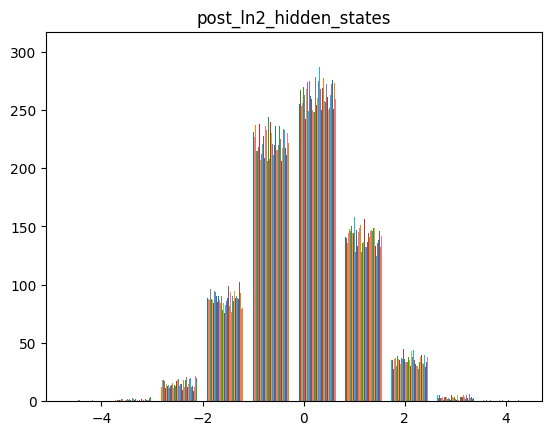

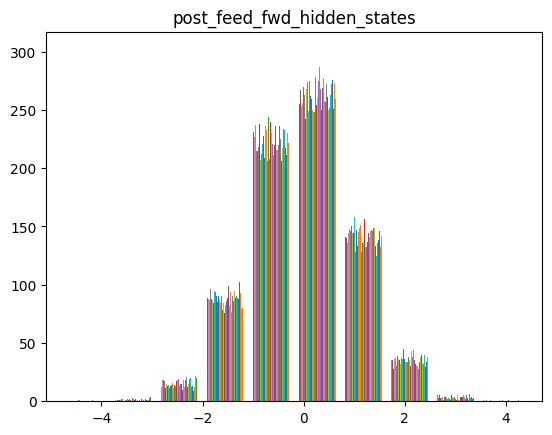

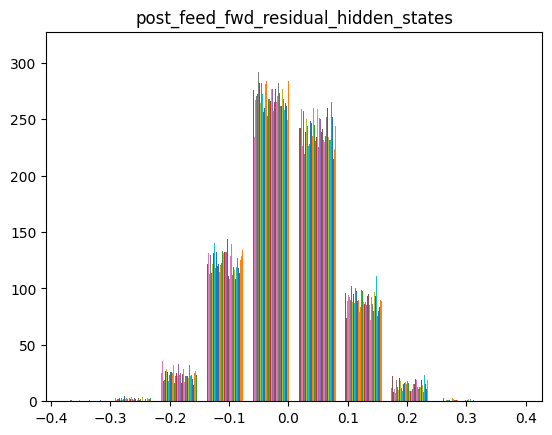

In [40]:
for key in h0_inter.keys():
    plt.figure()
    plt.hist(h0_inter[key][0])
    plt.title(key)